# Part 2 - Classification using fast.ai
In my last year's [eargasm music project](https://github.com/adamsiemaszkiewicz/eargasm-music), I classified my music library using pre-developed audio features extracted using Spotify API. This project is an attempt to test new ways of classifying sounds based on their raw sound representation and, later on, try to ensamble various different methods for a better performing classifier.

This notebook will use the audio clips converted into spectogram images in the previous step to build a classification model using fast.ai.

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/sound_classifier /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/sound_classifier': File exists
/content/gdrive/My Drive/Colab Notebooks/sound_classifier


## Import libraries
- `numpy` - linear algebra
- `pandas` -  data manipulation & analysis
- `shutil` - high-level file operations
- `tqdm` - progress bars
- `gc` - memory cleanup

In [3]:
import numpy as np
import pandas as pd
import shutil
import tqdm.notebook as tq
import gc

## fast.ai
Install & import the latest version of fast.ai high-level deep learning library and load its computer vision modules.

https://docs.fast.ai/

In [4]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.1)


In [5]:
import fastai
print(f'fast.ai version: {fastai.__version__}')
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.callback.all import *

fast.ai version: 2.3.1


## Reproducability
Set the global seed to ensure reproducability throughout the code.

In [6]:
set_seed(0)

# Preprocessing
In order to feed our data to the model we need to prepare our dataset first. The steps we're going to take are:
1. Load CSV file with dataset meta data
2. Set the path where the files are stored
3. Clean up duplicate files
4. Arrange dataset into predefined folds.

## Load meta data
Import CSV file containing meta information about the files in the dataset into a DataFrame.

In [7]:
# path to csv file containing meta data for the dataset
META_CSV = './ESC-50/meta/esc50.csv'

# load csv & preview the DataFrame
df = pd.read_csv(META_CSV)

# rename wav filenames to png & preview the DataFrame
df['filename'] = df['filename'].apply(lambda x: re.sub('wav', 'png', x))
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.png,1,0,dog,True,100032,A
1,1-100038-A-14.png,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.png,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.png,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.png,1,19,thunderstorm,False,101296,A


## Set dataset path
Set the main dataset path and list the files.

In [8]:
path = Path('./spectograms/')
path.ls()

(#2003) [Path('spectograms/3-152007-B-20.png'),Path('spectograms/3-152007-C-20.png'),Path('spectograms/3-152007-D-20.png'),Path('spectograms/3-152007-E-20.png'),Path('spectograms/3-152020-A-36.png'),Path('spectograms/3-152020-B-36.png'),Path('spectograms/3-152020-C-36.png'),Path('spectograms/3-152039-A-3.png'),Path('spectograms/3-152039-B-3.png'),Path('spectograms/3-152594-A-30.png')...]

## Duplicate files
Due to some Google Drive related bugs there might be some duplicate files. Let's clean them up before we continue.

In [9]:
# iterate through the files in the dataset path
for fname in os.listdir(path):

  # drop the file extension
  name = fname.split('.')[0]
  
  # check if the filename ends with (1) and remove the file
  if name.endswith('(1)'):
    print(os.path.join(path, fname))
    os.remove(os.path.join(path, fname))

# Large model
For the first experiment we're going to take all of our spectograms apart from fold 5, which we're taking away for a test set evaluation and their the convolutional neural network to classify our spectogram dataset.

## Data transformation
Define the transformations made to the dataset

- `item_tfms` transforms applied to the items before batching them (performed using the CPU) aka data preprocessing
- `batch_tfms` transforms applied to the batches once they are formed (performed using the GPU) aka data augmentation

First we preprocess our spectograms by squishing them into squares and resizing to 512px. After that we augment our data by randomly cropping the preprocessed spectograms.

https://docs.fast.ai/vision.augment.html

In [10]:
item_tfms = Resize(512, method=ResizeMethod.Squish)
batch_tfms = RandomCrop(256)

## Data Loaders
Let's build a DataLoaders object for a single fold using `from_df()` method and the DataFrame we've just created. To do it we need to define:
- `df` - DataFrame containing the dataset info
- `path` - path where the dataset files are stored
- `fn_col` - column name containing filenames
- `label_col` - column name containing labels
- `valid_col` - column name specifying validation samples
- `item_tfms` - transforms made to the items before batching 
- `batch_tfms` - transforms made to the items after batching 
- `bs` - batch size

`ImageDataLoaders` - https://docs.fast.ai/vision.data.html#ImageDataLoaders


In [11]:
# clip the original df to exclude one fold for a later evaluation
df_train = df.loc[df['fold'] != 5].copy()

# create DataLoaders object
dls = ImageDataLoaders.from_df(
    df=df_train,
    path=path,
    fn_col='filename',
    label_col='category',
    valid_pct=0.2,
    item_tfms=item_tfms,
    # batch_tfms=batch_tfms,
    bs=32
    )

### Preview batches
Let's see the data we've just loaded.

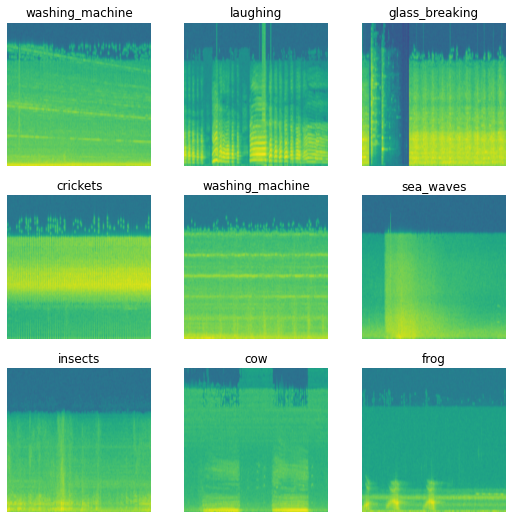

In [12]:
# preview one training batch
dls.train.show_batch()

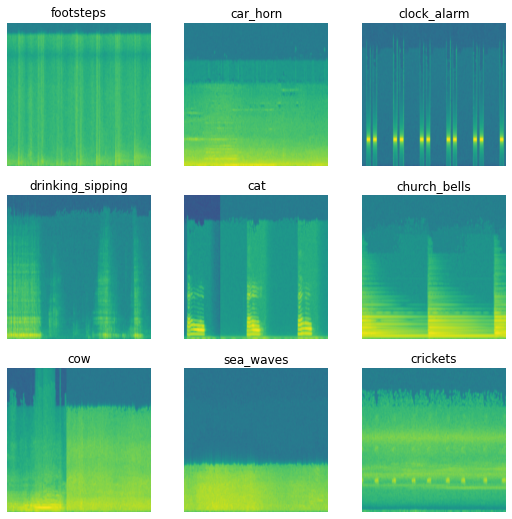

In [13]:
# preview one validation batch
dls.valid.show_batch()

## Learner
Create a convolutional netural network learner with:
- our previously made DataLoaders
- 34-layer ResNet CNN architecture
- error rate & accuracy evalutation metrics
- use transfer learning by downloading ResNet30 weights
- use mixed prevision to speed up training

https://docs.fast.ai/learner.html

In [14]:
learn = cnn_learner(
    dls=dls,
    arch=resnet34,
    metrics=[error_rate, accuracy],
    pretrained=True, # download pretrained weights 
    opt_func=Adam,
    loss_func=CrossEntropyLossFlat()
    )
# .to_fp16() # enable mixed precision

### Learner summary
Print a summary of the model, optimizer and loss function.

In [15]:
learn.summary()

Sequential (Input shape: 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 256 x 256 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

### Learning rate
Before training let's find an optimal learning rate for our model to learn quicker. To do so we need to select the learning rate value in the point where the steepness of the loss decline is the biggest or in 1/10 of the value of the lowest point.

https://docs.fast.ai/callback.schedule.html#Learner.lr_find

Lowest point /10: 6.92e-03, steepest point: 7.59e-03


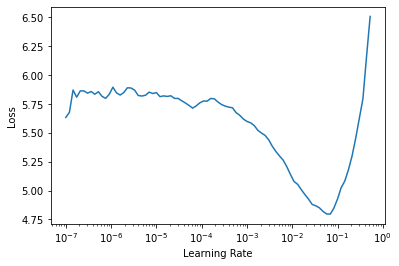

In [16]:
lr_min, lr_steep = learn.lr_find()
print(f'Lowest point /10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

### Callbacks
Additionally we'll use some callbacks to keep track of and react to the learning process:

- `EarlyStoppingCallback` that terminates training when monitored quantity stops improving

  We'll set patience to 5 in order to wait 5 epochs to see if there's still improvement with the training.

- `SaveModelCallback` that saves the model's best during training and loads it at the end

  We'll save the model together with its optimizer state and define the model name.

- `ReduceLROnPlateau` that reduces learning rate when a metric has stopped improving

  We'll set patience to 1 in order to wait 1 epoch to see if the change in the metric is smaller than 0.1, and then decrease the learning rate by the factor of 10. 

The eng goal of using these callbacks is to early-stop the model by following the values of `valid_loss` and terminate before our model starts overfitting the training data. After the training we're going to end up with the model with the lowest validation test loss.

https://docs.fast.ai/callback.tracker

In [17]:
cbs = [
       EarlyStoppingCallback(monitor='valid_loss', patience=5),
       SaveModelCallback(monitor='valid_loss', fname='full-model', with_opt=True),
      #  ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=1) 
       ]

## Training
Once we have a good learning rate to train our model, let's fine-tune the pretrained model. What the `fine_tune()` method does here is it:
- Trains the randomly added layers for one epoch, with all other layers frozen (epoch 0)
- Unfreezes all of the layers, and trains them all for the number of epochs requested
- Uses the optimal learning rate found in the previous step
- Tracks the progress of the learning with callbacks for early stopping.

https://docs.fast.ai/callback.schedule.html#Learner.fine_tune




In [18]:
learn.fine_tune(
    epochs=50,
    base_lr=lr_min,
    cbs=cbs
    )

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.026984,2.701327,0.668750,0.331250,00:17


Better model found at epoch 0 with valid_loss value: 2.701327323913574.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.663641,1.605492,0.421875,0.578125,00:21
1,1.004907,1.249355,0.334375,0.665625,00:20
2,0.597301,1.267351,0.315625,0.684375,00:21
3,0.370813,1.240416,0.337500,0.662500,00:20
4,0.276950,1.288208,0.325000,0.675000,00:21
5,0.241951,1.273928,0.328125,0.671875,00:21
6,0.312433,1.766846,0.431250,0.568750,00:21
7,0.465189,1.948120,0.428125,0.571875,00:20
8,0.568925,2.101527,0.425000,0.575000,00:20


Better model found at epoch 0 with valid_loss value: 1.6054919958114624.
Better model found at epoch 1 with valid_loss value: 1.2493549585342407.
Better model found at epoch 3 with valid_loss value: 1.2404162883758545.
No improvement since epoch 3: early stopping


### Learning curve
Plotting the losses of our model for both traininig and validation set we can see that our model reaches around 70% accuracy and the plateaus out.

https://docs.fast.ai/learner.html#Plotting-tools

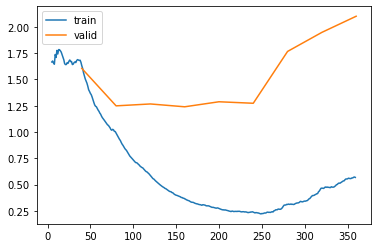

In [19]:
learn.recorder.plot_loss()

### Scheduler

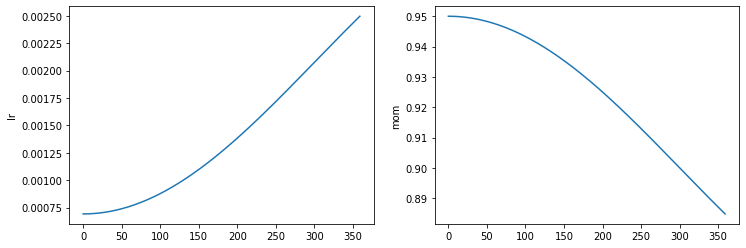

In [20]:
learn.recorder.plot_sched()

# Test set
Once our training and validation is done let's prepare the data our model hasn't seen before to later evaluate the model.

## Test DataFrame
Create a DataFrame containing the file paths to the test spectograms and their labels. We're goinig to use fold number 5 for the test purposes, as the model hasn't seen this data before.

In [21]:
# create a test DataFrame
df_test  = df.loc[df['fold']==5, :].copy()

# # change file extensions from wav to png to reflect our spectograms
# df_test['filename'] = df_test['filename'].apply(lambda x: 'fold5/'+x.split('.')[0]+'.png')
# df_test['filename'] = df_test['filename'].apply(lambda x: 'fold5/'+x.split('.')[0]+'.png')

# get rid of no longer needed columns and reset indexing
df_test = df_test.loc[:, ['filename', 'category']].reset_index(drop=True)

df_test.head()

,filename,category
0,5-103415-A-2.png,pig
1,5-103416-A-2.png,pig
2,5-103418-A-2.png,pig
3,5-103420-A-2.png,pig
4,5-103421-A-2.png,pig


## Test DataSet
Based on the DataFrame we've just generated, we can create a fast.ai `test_set` object which will contain tuples of our spectogram images and their labels.

https://docs.fast.ai/data.core.html#test_set

In [22]:
# make test set
tset = test_set(
    dsets=dls.valid_ds,
    test_items=df_test,
    with_labels=True
    )
tset

(#400) [(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(34))...]

### Label vocabulary
Print a dictionary with the encoded labels.

In [23]:
tset.vocab.o2i

{'airplane': 0,
 'breathing': 1,
 'brushing_teeth': 2,
 'can_opening': 3,
 'car_horn': 4,
 'cat': 5,
 'chainsaw': 6,
 'chirping_birds': 7,
 'church_bells': 8,
 'clapping': 9,
 'clock_alarm': 10,
 'clock_tick': 11,
 'coughing': 12,
 'cow': 13,
 'crackling_fire': 14,
 'crickets': 15,
 'crow': 16,
 'crying_baby': 17,
 'dog': 18,
 'door_wood_creaks': 19,
 'door_wood_knock': 20,
 'drinking_sipping': 21,
 'engine': 22,
 'fireworks': 23,
 'footsteps': 24,
 'frog': 25,
 'glass_breaking': 26,
 'hand_saw': 27,
 'helicopter': 28,
 'hen': 29,
 'insects': 30,
 'keyboard_typing': 31,
 'laughing': 32,
 'mouse_click': 33,
 'pig': 34,
 'pouring_water': 35,
 'rain': 36,
 'rooster': 37,
 'sea_waves': 38,
 'sheep': 39,
 'siren': 40,
 'sneezing': 41,
 'snoring': 42,
 'thunderstorm': 43,
 'toilet_flush': 44,
 'train': 45,
 'vacuum_cleaner': 46,
 'washing_machine': 47,
 'water_drops': 48,
 'wind': 49}

### Sample
Display a sample spectogram from the test set together with its actual label.

'coughing'

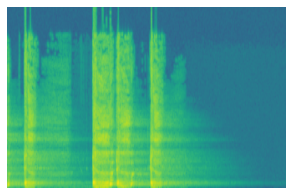

In [24]:
# pick a random number
random_no = np.random.randint(0, 400)
# test set sample
sample = tset[random_no]
# show a sample test spectogram
sample[0].show()
# create a transformer of category string to vocab id
cat = Categorize(vocab=tset.vocab)
# show a sample test label by decoding vocab id
cat.decode(sample[1])

## Test DataLoader
Create a test DataLoader from our test Dataset using validation transforms of our original DataLoaders (`dls`) along with the test labels and show one batch of the samples.

https://docs.fast.ai/data.core.html#DataLoaders.test_dl

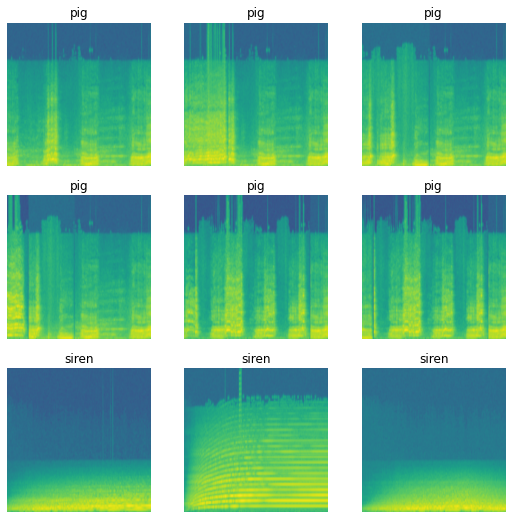

In [25]:
test_dl = dls.test_dl(
    dsets=dls.valid_ds,
    test_items=df_test,
    with_labels=True,
    )
test_dl.show_batch()

# Evaluation
Let's interpret the results of our classification.

https://docs.fast.ai/interpret

## Classification results
Let's see some sample predictions of our model. Each sample is marked either green (correct prediction) or red (false prediction) labeled with ground truth (top) and prediction (bottom).

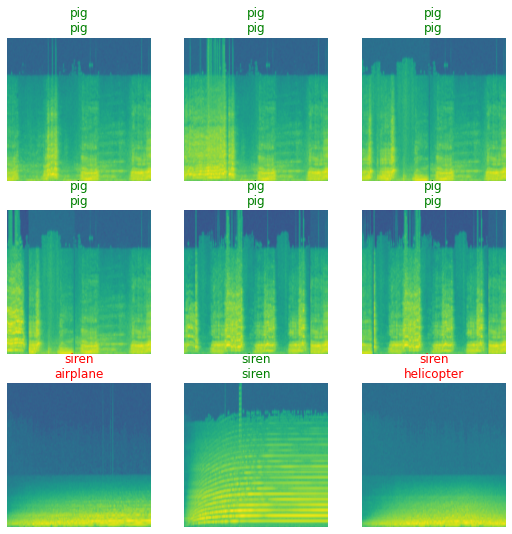

In [26]:
learn.show_results(dl=test_dl, shuffle=True)

### Sample prediction
Let's pick a random sample from our test set and see what the model we've just trained predicts. The `predict()` method will output:
- `pred` - predicted category
- `pred_enc` - predicted category (encoded)
- `probs` - raw probabilities of each category

On top of that let's encode the actual category and print all of the info.

In [27]:
# pick a random number
random_no = np.random.randint(0, 400)
# pick a random test set spectogram
img, label = tset[random_no]
# predict the category of a spectogram 
pred, pred_enc, probs = learn.predict(img)
# decode label name
hat=cat.decode(label)

print(f'''
Actual:                 {hat}
Predicted:              {pred}
Predicted (encoded):    {pred_enc}
       ''')


Actual:                 cat
Predicted:              cat
Predicted (encoded):    5
       


### Prediction confidence
Let's use the raw prediction probabilities from the previous cell and display them in a readable format.

In [28]:
# create a dict with decoded cateogry names as keys and corresponding probability as a value
pred_dict = {tset.vocab[n]:[p.item()] for n, p in enumerate(probs)}
# create a DataFrame from the dictionary
pred_df = pd.DataFrame(pred_dict)
# transpose the DataFrame and sort the values for better readibility
pred_df = pred_df.T.sort_values(by=0, ascending=False)
# rename the columns and display the top 5 results
pred_df.columns=['confidence']
pred_df.head()

,confidence
cat,0.995706
coughing,0.000783
hen,0.000763
crying_baby,0.000599
breathing,0.000456


## Results interpretation
Let's interpret the results of our test set evaluation using `ClassificationInterpretation`.

In [29]:
interp_test = ClassificationInterpretation.from_learner(learn, dl=test_dl)

### Confusion matrix
Plot the confusion matrix to see the full representation of correct and false predictions ouf our basic model.

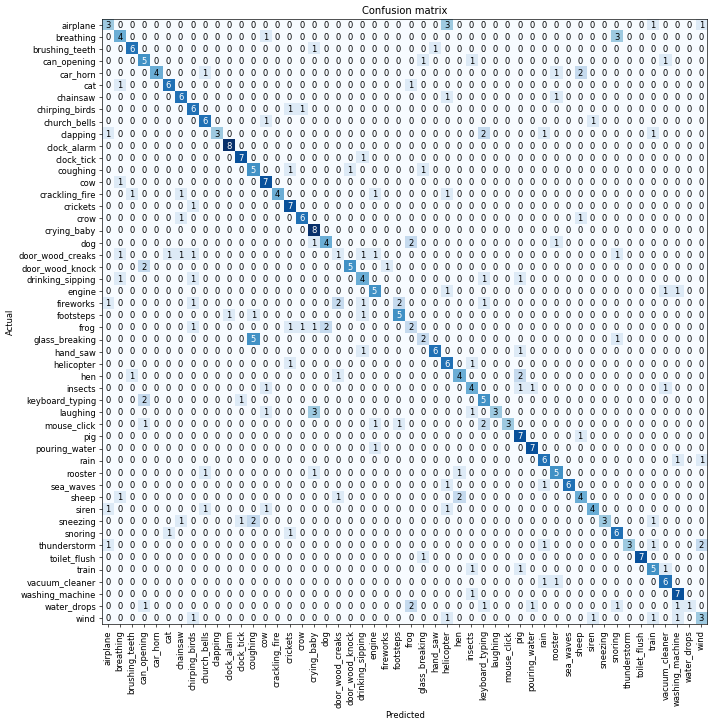

In [30]:
interp_test.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Most confused
Let's see a list of largest confused predictions, presented as tuples of (actual class, predicted class, number of occurrences), with a minimal value of 3 confused predictions.

In [31]:
interp_test.most_confused(min_val=3)

[('glass_breaking', 'coughing', 5),
 ('airplane', 'helicopter', 3),
 ('breathing', 'snoring', 3),
 ('laughing', 'crying_baby', 3)]

### Classification report
Print scikit-learn classification report for our model. To get a better sense of mathematical performance of the model we can check the classification report containing values of metrics such as:
- $Precision = \frac{TP}{TP+FP}$ (What proportion of positive identifications was actually correct?)
- $Recall = \frac{TP}{TP+FN}$ (What proportion of actual positives was identified correctly?)
- $F1\ score = \frac{TP}{TP+1/2(FP+FN)}$ (The harmonic mean of precision and recall)
- $Accuracy = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions}$ (What proportion of predictions was correct?)

where:

$TP - true\ positive$

$TN - true\ negative$

$FP - false\ positive$

$FN - false\ negative$

In [32]:
interp_test.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.43      0.38      0.40         8
       breathing       0.44      0.50      0.47         8
  brushing_teeth       0.75      0.75      0.75         8
     can_opening       0.45      0.62      0.53         8
        car_horn       1.00      0.50      0.67         8
             cat       0.75      0.75      0.75         8
        chainsaw       0.60      0.75      0.67         8
  chirping_birds       0.50      0.75      0.60         8
    church_bells       0.67      0.75      0.71         8
        clapping       1.00      0.38      0.55         8
     clock_alarm       0.89      1.00      0.94         8
      clock_tick       0.78      0.88      0.82         8
        coughing       0.38      0.62      0.48         8
             cow       0.58      0.88      0.70         8
  crackling_fire       1.00      0.50      0.67         8
        crickets       0.58      0.88      0.70         8
            c

# Ensamble model
Let's take a different approach and build a ensemble predictor using four small models trained using different folds instead of one big model we've did before. 

Let's repeat the steps and settings we took with the previous model for each fold and save the trained models into a dictionary:

1. Create a ImageDataLoaders object similarily to the basic model 
2. Initiate the learner with a deeper ResNet network with 50 hidden layers
3. Take advantage of the callbacks we used before for early training stopping.
4. Find an optimal learning late for each fold (this time taking the minimum/10 point for more robustness and automatization).
5. Clear cache using Garbage Collector Python library to avoid running into CUDA memory problems.

## Cross-validation folds
The dataset is divided into 5 folds which we need to keep in order to avoid data leakage, as some of the audio files come from the same recording. Let's keep each fold seperately in their corresponding folder.

### List files
Let's create a DataFrame listing files belonging to each fold.

In [33]:
# # specify number of folds available
# FOLDS_NUMBER = 5

# # make a dict comprehension with list of filenames for each fold
# folds_dict = {
#           f'fold{n+1}':[f for f in df.loc[df['fold'] == n+1].filename] \
#           for n in range(FOLDS_NUMBER)
#          }

# # create and preview a DataFrame based on the dictionary
# df_folds = pd.DataFrame(folds_dict)
# df_folds.head()

,fold1,fold2,fold3,fold4,fold5
0,1-100032-A-0.png,2-100648-A-43.png,3-100018-A-18.png,4-102844-A-49.png,5-103415-A-2.png
1,1-100038-A-14.png,2-100786-A-1.png,3-100024-A-27.png,4-102844-B-49.png,5-103416-A-2.png
2,1-100210-A-36.png,2-101676-A-10.png,3-100024-B-27.png,4-102844-C-49.png,5-103418-A-2.png
3,1-100210-B-36.png,2-102414-A-17.png,3-101381-A-33.png,4-102871-A-42.png,5-103420-A-2.png
4,1-101296-A-19.png,2-102414-B-17.png,3-101381-B-33.png,4-107117-A-33.png,5-103421-A-2.png


### Create directories
Create folders for each fold to store the spectogram files.

In [34]:
# # iterate through folds
# for fold in df_folds.columns:

#   # set the directory path
#   dir = path/fold
  
#   # create folder if it doesn't exist yet
#   if not os.path.isdir(dir):
#     os.mkdir(dir)
#     print(f'Directory {dir} created.')
#   else:
#     print(f'Directory {dir} already exists.')

### Copy files
Copy spectogram files to the corresponding folders, so it's possible for fast.ai to process them.

In [35]:
# # iterate through folds
# for fold in df_folds.columns:

#   # iterate through files within a fold
#   for file in df_folds[fold]:

#     # change file extension from wav to png
#     file = re.sub('wav', 'png', file)

#     # check if file already exists and copy from source to destination if it doesn't
#     if not os.path.exists(path/fold/file):
#       shutil.copy(path/file, path/fold)
#       print(f'Copied {file} to {fold}')
#     else:
#       print(f'File {file} already exists.')

## Single fold DataFrame
Define a function to crate a DataFrame to use in each fold's training. We'll exclude fold number 5, which will be used later as a test set.

In [36]:
def fold_df(fold_number):
  '''Create a DataFrame with data for a single fold training.'''

  # create a training set
  df_train = df.loc[df['fold']!=5, :].copy()

  # replace original wav audio file extension with spectogram png extension
  df_train['filename'] = df_train['filename'] \
                        .apply(lambda x: x.split('.')[0])+'.png'

  # tag validation samples based on specified fold number
  df_train['is_valid'] = df_train['fold'] \
                        .apply(lambda x: True if x==fold_number else False)

  # get rid of columns we no longer need
  df_train = df_train.drop(
      columns=['fold', 'target', 'esc10', 'src_file', 'take']
      )
  
  # reset index
  df_train = df_train.reset_index(drop=True)
  
  return df_train

In [37]:
# display sample single fold DataFrame
fold_df(4)

,filename,category,is_valid
0,1-100032-A-0.png,dog,False
1,1-100038-A-14.png,chirping_birds,False
2,1-100210-A-36.png,vacuum_cleaner,False
3,1-100210-B-36.png,vacuum_cleaner,False
4,1-101296-A-19.png,thunderstorm,False
...,...,...,...
1595,4-99193-B-4.png,frog,True
1596,4-99644-A-4.png,frog,True
1597,4-99644-B-4.png,frog,True
1598,4-99644-C-4.png,frog,True


In [38]:
%%time

# initiate an empty dictionary to store the trained models
learners = dict()

# iterate through available folds
for n in tq.tqdm(range(1,5)):

  print(f'\nTraining fold {n}...') 

  # create DataLoaders object
  dls_tmp = ImageDataLoaders.from_df(
      df=fold_df(n),
      path=path,
      fn_col='filename',
      label_col='category',
      valid_col='is_valid',
      item_tfms=Resize(512, method=ResizeMethod.Squish),
      bs=32
      )
  
  # define a learner
  learn_tmp = cnn_learner(
    dls=dls_tmp,
    arch=resnet34,
    metrics=[error_rate, accuracy],
    pretrained=True
    )
  # .to_fp16() # use mixed precision to speed up training

  # find learning rate & supress plot display
  lr_min, lr_steep = learn_tmp.lr_find(show_plot=False)

  # define list of callbacks to use
  cbs = [
       EarlyStoppingCallback(monitor='valid_loss', patience=5),
       SaveModelCallback(monitor='valid_loss', fname=f'ensemble-model{n}', with_opt=True),
      #  ReduceLROnPlateau(monitor='valid_loss', min_delta=0.1, patience=1) 
       ]

  # train a model
  learn_tmp.fine_tune(
      epochs=50,
      base_lr=lr_min,
      cbs=cbs
      )

  # append learner to the container
  learners[f'fold{n}'] = learn_tmp 

  # collect memory garbage to avoid CUDA out of memory error
  del learn_tmp
  gc.collect()
  torch.cuda.empty_cache()  


Training fold 1...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.198569,3.299493,0.785000,0.215000,00:16


Better model found at epoch 0 with valid_loss value: 3.2994933128356934.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.873741,2.209522,0.590000,0.410000,00:20
1,1.257423,1.970946,0.547500,0.452500,00:20
2,0.865173,1.868828,0.500000,0.500000,00:20
3,0.576528,1.852767,0.480000,0.520000,00:20
4,0.388918,1.738775,0.485000,0.515000,00:20
5,0.267175,1.821652,0.475000,0.525000,00:20
6,0.198083,1.790949,0.462500,0.537500,00:20
7,0.170950,1.863243,0.465000,0.535000,00:20
8,0.206444,2.134852,0.512500,0.487500,00:20
9,0.280102,2.056369,0.475000,0.525000,00:20


Better model found at epoch 0 with valid_loss value: 2.209521770477295.
Better model found at epoch 1 with valid_loss value: 1.9709463119506836.
Better model found at epoch 2 with valid_loss value: 1.8688277006149292.
Better model found at epoch 3 with valid_loss value: 1.852766752243042.
Better model found at epoch 4 with valid_loss value: 1.7387750148773193.
No improvement since epoch 4: early stopping

Training fold 2...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.156423,3.407064,0.772500,0.227500,00:16


Better model found at epoch 0 with valid_loss value: 3.407064199447632.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.739599,1.904235,0.505000,0.495000,00:20
1,1.111366,1.592985,0.450000,0.550000,00:20
2,0.686851,1.471462,0.405000,0.595000,00:20
3,0.432469,1.410077,0.385000,0.615000,00:20
4,0.285031,1.512071,0.420000,0.580000,00:20
5,0.223811,1.617322,0.405000,0.595000,00:20
6,0.239568,1.940012,0.450000,0.550000,00:20
7,0.352766,1.747771,0.432500,0.567500,00:20
8,0.447814,1.929269,0.457500,0.542500,00:20


Better model found at epoch 0 with valid_loss value: 1.9042346477508545.
Better model found at epoch 1 with valid_loss value: 1.5929847955703735.
Better model found at epoch 2 with valid_loss value: 1.4714622497558594.
Better model found at epoch 3 with valid_loss value: 1.4100768566131592.
No improvement since epoch 3: early stopping

Training fold 3...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.101370,3.060479,0.720000,0.280000,00:17


Better model found at epoch 0 with valid_loss value: 3.060479164123535.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.673925,1.895893,0.515000,0.485000,00:20
1,1.032616,1.717286,0.480000,0.520000,00:20
2,0.624231,1.499104,0.412500,0.587500,00:20
3,0.406670,1.553074,0.427500,0.572500,00:20
4,0.281661,1.597043,0.447500,0.552500,00:20
5,0.224878,1.682882,0.445000,0.555000,00:20
6,0.260462,2.152725,0.502500,0.497500,00:20
7,0.377326,2.127362,0.492500,0.507500,00:20


Better model found at epoch 0 with valid_loss value: 1.8958929777145386.
Better model found at epoch 1 with valid_loss value: 1.7172858715057373.
Better model found at epoch 2 with valid_loss value: 1.4991039037704468.
No improvement since epoch 2: early stopping

Training fold 4...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.072913,3.524764,0.715000,0.285000,00:16


Better model found at epoch 0 with valid_loss value: 3.524763822555542.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.723393,1.769753,0.472500,0.527500,00:20
1,1.057554,1.565698,0.422500,0.577500,00:20
2,0.634354,1.311980,0.350000,0.650000,00:20
3,0.416157,1.466481,0.385000,0.615000,00:20
4,0.300861,1.430825,0.355000,0.645000,00:20
5,0.275410,1.596633,0.405000,0.595000,00:20
6,0.365117,1.992642,0.455000,0.545000,00:20
7,0.529362,2.232057,0.445000,0.555000,00:20


Better model found at epoch 0 with valid_loss value: 1.769752860069275.
Better model found at epoch 1 with valid_loss value: 1.5656977891921997.
Better model found at epoch 2 with valid_loss value: 1.311980128288269.
No improvement since epoch 2: early stopping

CPU times: user 7min 10s, sys: 4min 7s, total: 11min 18s
Wall time: 15min 44s


## Get predictions
Once we've got our small models trained, let's see how they perform on our test set by using `get_preds` method with some additional attributes. Let's run the method through each model and put them inside a dictionary. 

`get_preds` will output a 5-element-tuple with:
- `inputs` - list of PILimage inputs 
- `preds` - tensor of the raw predictions for each category
- `targs` - tensor of actual categories
- `decoded` - tensor of decoded prediction category names
- `losses` - tensor of losses for each prediction

https://docs.fast.ai/learner.html#Learner.get_preds

### Seperately
Calculate the predictions for each model seperately.

In [39]:
ensemble_preds = {
    f'ensemble{n}':learners[f'fold{n}'].get_preds(
        dl=test_dl,
        with_input=True,
        with_decoded=True,
        with_loss=True
        ) for n in tq.tqdm(range(1,5))}

# clear memory
gc.collect()
torch.cuda.empty_cache() 

### Combined
Once we have predictions for each model seperately, let's combine those results into one prediction by:

1. For both input images (`inputs`) and target categories (`targs`) we can we whichever model we want, because those are the same for each one
2. For both the raw predictions (`preds`) and the losses (`losses`) we need to do a element-wise mean to find out an evarage prediction/loss value for each input
3. Using our mean predictions we need to extract the biggest confidence value for each prediction to decode the predicted category (`decoded`)

In [40]:
# take the inputs from whichever prediction
inputs = ensemble_preds['ensemble1'][0]

# take an element-wise mean of predictions
preds_list = [ensemble_preds[f'ensemble{n}'][1] for n in tq.tqdm(range(1,5))]
preds = (preds_list[0] + \
         preds_list[1] + \
         preds_list[2] + \
         preds_list[3])/len(preds_list)

# take the actual labels from whichever prediction
targs = ensemble_preds['ensemble1'][2]

# take an element-wise mean of losses
losses_list = [ensemble_preds[f'ensemble{n}'][4] for n in tq.tqdm(range(1,5))]
losses = (losses_list[0] + \
          losses_list[1] + \
          losses_list[2] + \
          losses_list[3])/len(losses_list)

# take index of the most confident prediction from each raw predictions
decoded = torch.argmax(preds, dim=1)

gc.collect()
torch.cuda.empty_cache() 

# Evaluation
Let's interpret the results of our classification.

https://docs.fast.ai/interpret

## Results interpretation
Let's interpret the results of our test set evaluation using `ClassificationInterpretation` using the prediction values we've just calculated.

In [41]:
interp_ensemble = ClassificationInterpretation(
    test_dl,
    inputs,
    preds,
    targs,
    decoded,
    losses
    )

### Confusion matrix
Plot the confusion matrix to see the full representation of correct and false predictions ouf our basic model.

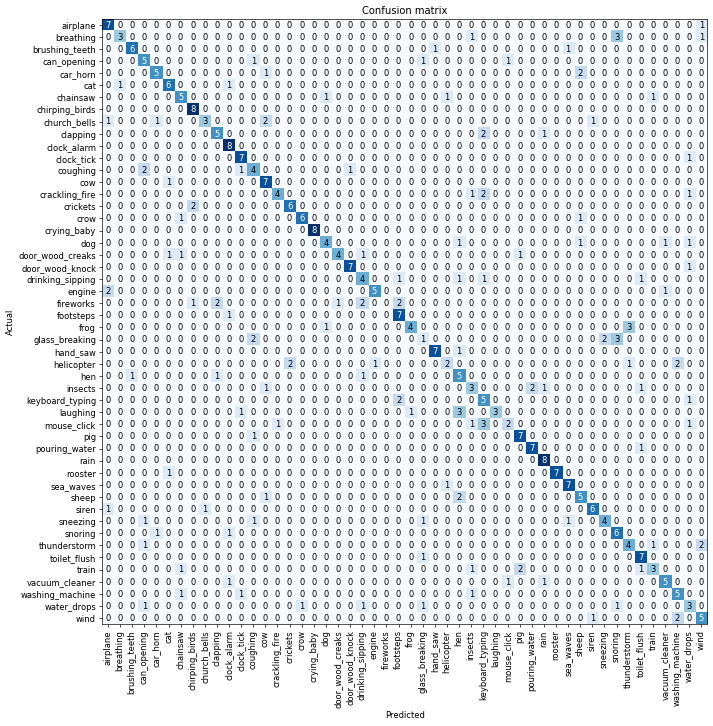

In [42]:
interp_ensemble.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Most confused
Let's see a list of largest confused predictions, presented as tuples of (actual class, predicted class, number of occurrences), with a minimal value of 3 confused predictions.

In [43]:
interp_ensemble.most_confused(min_val=3)

[('breathing', 'snoring', 3),
 ('frog', 'thunderstorm', 3),
 ('glass_breaking', 'snoring', 3),
 ('laughing', 'hen', 3),
 ('mouse_click', 'keyboard_typing', 3)]

### Classification report
Print scikit-learn classification report for our model. To get a better sense of mathematical performance of the model we can check the classification report containing values of metrics such as:
- $Precision = \frac{TP}{TP+FP}$ (What proportion of positive identifications was actually correct?)
- $Recall = \frac{TP}{TP+FN}$ (What proportion of actual positives was identified correctly?)
- $F1\ score = \frac{TP}{TP+1/2(FP+FN)}$ (The harmonic mean of precision and recall)
- $Accuracy = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions}$ (What proportion of predictions was correct?)

where:

$TP - true\ positive$

$TN - true\ negative$

$FP - false\ positive$

$FN - false\ negative$

In [44]:
interp_ensemble.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.64      0.88      0.74         8
       breathing       0.75      0.38      0.50         8
  brushing_teeth       0.86      0.75      0.80         8
     can_opening       0.50      0.62      0.56         8
        car_horn       0.71      0.62      0.67         8
             cat       0.67      0.75      0.71         8
        chainsaw       0.56      0.62      0.59         8
  chirping_birds       0.73      1.00      0.84         8
    church_bells       0.75      0.38      0.50         8
        clapping       0.62      0.62      0.62         8
     clock_alarm       0.67      1.00      0.80         8
      clock_tick       0.70      0.88      0.78         8
        coughing       0.44      0.50      0.47         8
             cow       0.58      0.88      0.70         8
  crackling_fire       0.80      0.50      0.62         8
        crickets       0.75      0.75      0.75         8
            c

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusions
As we can see, ensembling a couple of smaller models built on top of predefined cross-validation folds gives us performance on the test set 4% higher than the model trained on the whole dataset at once. 

## To do list
- Experiment with State of the Art architectures such as EfficientNet or YOLO.